In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import Counter

## The native Python waveform-database (WFDB) package. 
## A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb
import random
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
data_path="mit-bih-arrhythmia-database-1.0.0/"

#### List of patients

In [4]:
pts=[str(x) for x in range(100,125)]+[str(x) for x in range(200,224)]+[str(x) for x in range(228,235)]
for x in ["110","120","204","206","211","216","218","229"]:
    pts.remove(x)

print("Number of cases: ", len(pts))
print(pts)

Number of cases:  48
['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


#### To check the distribution of differet types of beats

In [19]:
## method 1
syms = [wfdb.rdann(data_path + pt,"atr").symbol for pt in pts]
syms = list(itertools.chain(*syms))
final_dict=dict(Counter(syms))
final_dict

{'+': 1291,
 'N': 75052,
 'A': 2546,
 'V': 7130,
 '~': 616,
 '|': 132,
 'Q': 33,
 '/': 7028,
 'f': 982,
 'x': 193,
 'F': 803,
 'j': 229,
 'L': 8075,
 'a': 150,
 'J': 83,
 'R': 7259,
 '[': 6,
 '!': 472,
 ']': 6,
 'E': 106,
 'S': 2,
 '"': 437,
 'e': 16}

In [ ]:
# method 2
final_dict=dict()
for pt in pts:
    d=dict()
    file=data_path+pt
    annotation=wfdb.rdann(file,"atr")
    syms=annotation.symbol
    for sym in syms:
        d[sym]=d.get(sym,0)+1
    for k,v in d.items():
        if k not in final_dict.keys():
            final_dict[k]=v
        else:
            final_dict[k]=final_dict[k]+v

pd.Series(final_dict).sort_values(ascending=False)

**List of nonbeat and abnormal beats symbols:**

The symbols for the annotations can be found at https://archive.physionet.org/physiobank/annotations.shtml

In [30]:
nonbeats=["[","]","!","x","(",")","p","t","u","`",
          "\"","^","|","~","+","s","T","*","D","=","@","Q","?"]
abnormals=["L","R","V","/","A","f","F","j","a","E","J","e","S"]

agg=nonbeats+abnormals

#### Distribution of normal and abnormal beats:

In [31]:
cat={"non_beats":0,"abnormal":0,"normal":0}
for k,v in final_dict.items():    
    if k in nonbeats:
        cat["non_beats"]=cat["non_beats"]+v
    elif k in abnormals:
        cat["abnormal"]=cat["abnormal"]+v
    else:
        cat["normal"]=cat["normal"]+v  

pd.Series(cat).sort_values(ascending=False)

normal       75052
abnormal     34409
non_beats     3186
dtype: int64

#### Function for loading ECG file:

In [32]:
def load_ecg(file):
    # load the ecg
    # example: "mit-bih-arrhythmia-database-1.0.0/101"
    record=wfdb.rdrecord(file)
    # load the annotation
    annotation=wfdb.rdann(file,"atr")
    # extract the signal
    p_signal=record.p_signal
    # verify frequency is 360
    assert record.fs ==360, "sample freq is not 360"
    
    # extract symbols and annotation index
    atr_sym=annotation.symbol
    atr_sample=annotation.sample

    return p_signal,atr_sym,atr_sample

#### Running the function for the first patient as an example:

In [33]:
file=data_path+pts[0]
p_signal,atr_sym,atr_sample=load_ecg(file)

In [34]:
## list of abnormal beats index
ab_index=[]
for sym,ind in zip(atr_sym,atr_sample):
    if sym in abnormals:
        ab_index.append(ind)
        
## list of normal beats index
nor_index=[]
for sym,ind in zip(atr_sym,atr_sample):
    if sym not in agg:
        nor_index.append(ind)

#### Plotting the signal around one of the abnormal beats:

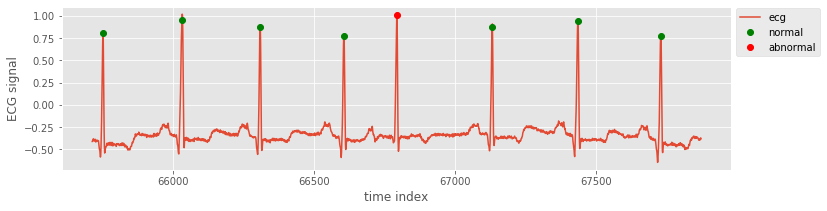

In [35]:
plt.style.use('ggplot')
T=range(len(p_signal))
left=int(ab_index[1]-360*3)  ## 3 seconds before
right=int(ab_index[1]+360*3) ## 3 seconds after 
interval=T[left:right]

def subset(ls,interval):
    d=[]
    for x in ls:
        if x in interval:
            d.append(x)
    sig=[p_signal[t,0] for t in d]
    return(d,sig)

plt.figure(figsize=(12,3))
plt.plot(interval,p_signal[left:right,0],label="ecg")
plt.plot(subset(nor_index,interval)[0],subset(nor_index,interval)[1],"o",label="normal",color="g")
plt.plot(subset(ab_index,interval)[0],subset(ab_index,interval)[1],"o",color="r",label="abnormal");
plt.xlabel("time index")
plt.ylabel("ECG signal")
plt.legend(bbox_to_anchor=(1, 1.02));

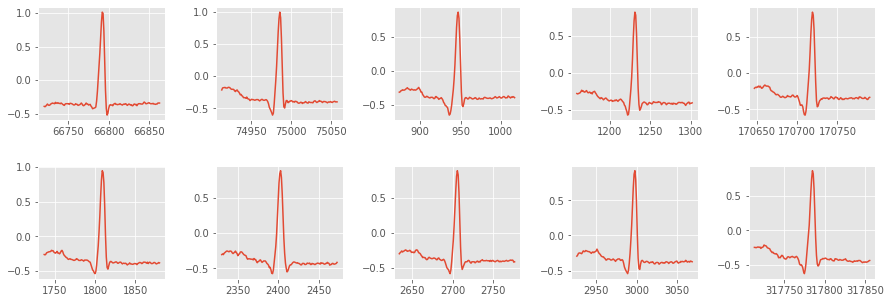

In [36]:
fs=360
num_sec=0.2
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(2, 5, i)
    ## random choice between normal and abnormal 
    rand=random.choice((ab_index,nor_index))
    left=int(rand[i]-fs*num_sec)  ## .2 seconds before
    right=int(rand[i]+fs*num_sec) ## .2 seconds after 
    interval=T[left:right]
    ax.plot(interval,p_signal[left:right,0])
    

In [39]:
def make_dataset(pts,num_sec,fs):
    """
    function for extracting normal and abnormal beats
    input:
    pts: list of patients
    num_sec= number of seconds for including before and after the beat
    fs= frequency
    output:
    X_all=signal within the time window of 2*num_sec
    Y_all=binary, 0: normal, 1:abnormal
    sym_all=beat annotation symbol
    patient_id= patient id
    """
    num_cols=int(2*num_sec *fs) 
    X_all=np.zeros((1,num_cols))
    Y_all=np.zeros((1,1))
    sym_all=[]
    patient_id=[]
    
    max_rows=[]
    for pt in pts:
        file=data_path+pt
        p_signal,atr_sym,atr_sample=load_ecg(file)
        p_signal=p_signal[:,0]
        
        df_ann=pd.DataFrame({"atr_sym":atr_sym,"atr_sample":atr_sample})
        df_ann=df_ann.loc[df_ann.atr_sym.isin(abnormals+["N"])]
        
        num_rows=len(df_ann)
        
        X=np.zeros((num_rows,num_cols))
        Y=np.zeros((num_rows,1))
        
        max_row=0
        for atr_sample,atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):
            left=max([0,(atr_sample-int(num_sec*fs))])
            right=min([len(p_signal),(atr_sample+int(num_sec*fs))])
            x=p_signal[left:right]
            if len(x)== num_cols:
                X[max_row,:]=x
                Y[max_row,:]=int(atr_sym in abnormals)
                sym_all.append(atr_sym)
                patient_id.append(pt)
                max_row +=1
        X = X[:max_row,:]
        Y = Y[:max_row,:]
        max_rows.append(max_row)
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of rows messed up'
    
    return X_all, Y_all, sym_all, patient_id

In [40]:
X, Y, sym, patient=make_dataset(pts,num_sec=.2,fs=360)

In [41]:
Y_list=Y.flatten().tolist()
## index of abnormal beats 
ind_ab=[i for i, e in enumerate(Y_list) if e == 1]

## patient with abnormal beats
pwab={}
for x in [patient[i] for i in ind_ab]:
    pwab[x]=pwab.get(x,0)+1

print(pwab)
#q3=np.quantile([v for k, v in pwab.items()],.75)

#[k for k, v in pwab.items() if v > q3]

{'100': 34, '101': 3, '102': 2088, '103': 2, '104': 2048, '105': 41, '106': 520, '107': 2137, '108': 24, '109': 2531, '111': 2124, '112': 2, '113': 6, '114': 59, '116': 110, '117': 1, '118': 2277, '119': 444, '121': 2, '123': 3, '124': 1619, '200': 858, '201': 338, '202': 75, '203': 447, '205': 85, '207': 1859, '208': 1366, '209': 384, '210': 227, '212': 1825, '213': 610, '214': 2259, '215': 168, '217': 1964, '219': 72, '220': 94, '221': 396, '222': 421, '223': 576, '228': 365, '230': 1, '231': 1257, '232': 1780, '233': 848, '234': 53}


Distribution of diffrent beats:

In [42]:
d={}
for x in sym:
    d[x]=d.get(x,0)+1
print(d)

{'N': 75040, 'A': 2546, 'V': 7129, '/': 7028, 'f': 982, 'F': 802, 'j': 229, 'L': 8073, 'a': 150, 'J': 83, 'R': 7257, 'E': 106, 'S': 2, 'e': 16}


Dimentionality reduction using PCA() for the sake of visualization 

In [44]:
pca=decomposition.PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

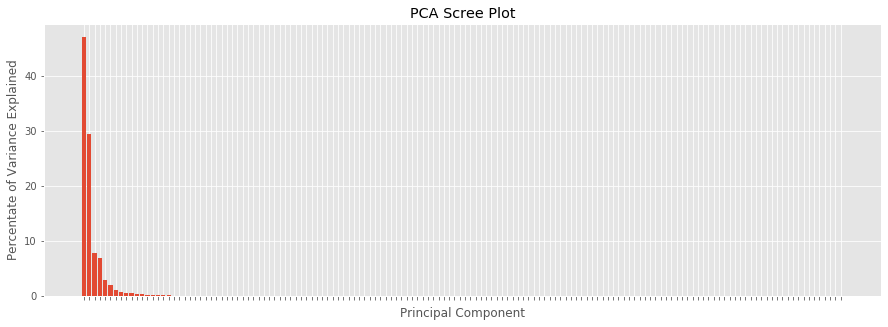

In [45]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ["PC%d"%(i+1) for i in range(0,X.shape[1])] 
plt.figure(figsize=(15, 5))
plt.bar(x= range(0,X.shape[1]), height=percent_variance, tick_label="")
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

In [46]:
pca_new=decomposition.PCA(n_components=2)
pca_new.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

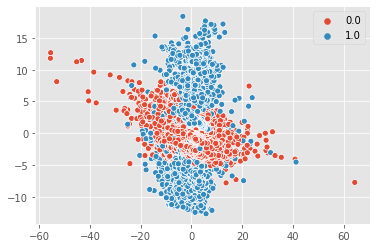

In [47]:
X_reduced=pca_new.transform(X)
import seaborn as sns
sns.scatterplot(X_reduced[:,0],X_reduced[:,1],hue=Y.flatten());

Classification modeling:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y.flatten(), test_size=0.33)

In [49]:
## Receiver operating characteristic (ROC) plot
def ROC (tpr,fpr,roc_auc):
    plt.plot(tpr, fpr, color='r',label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    #plt.xticks(np.arange(0,1.1,.1))
    #plt.yticks(np.arange(0,1.1,.1))
    plt.xlabel('False positive rate (1-Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid();

## confusion matrix plot
def plot_cm(y_test, y_est):
    cm = confusion_matrix(y_test, y_est);
    accuracy = np.round(100*cm.diagonal().sum()/cm.sum(),2); error_rate = np.round(100-accuracy,2)
    plt.imshow(cm, cmap='binary', interpolation='None')
    plt.colorbar()
    plt.xlabel('Predicted class'); plt.ylabel('Actual class');
    plt.title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

In [50]:
classifiers = [
    RandomForestClassifier(n_estimators=100),
    LogisticRegression(solver='lbfgs',max_iter=1000), # without solver='lbfgs' it gives warning
    KNeighborsClassifier(3),
    MLPClassifier(activation='logistic',max_iter=1000),
    DecisionTreeClassifier()
    ]

classifiers_names=["RandomForest: \n",
                   "Logistic Regression: \n",
                   "K Nearest Neighbors: \n",
                   "Neural Networks: \n",
                   "Decision Tree: \n"]

RandomForest: 
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     24846
         1.0       0.99      0.95      0.97     11271

    accuracy                           0.98     36117
   macro avg       0.98      0.97      0.98     36117
weighted avg       0.98      0.98      0.98     36117



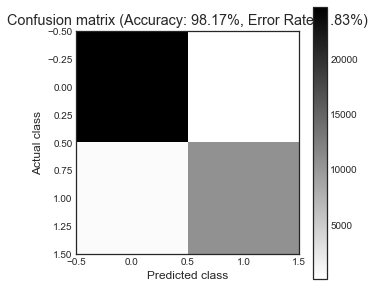

<Figure size 288x288 with 0 Axes>

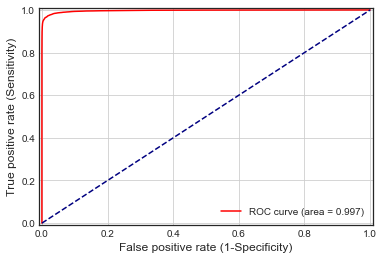

---------------------------------------------------------


Logistic Regression: 
               precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     24846
         1.0       0.84      0.69      0.75     11271

    accuracy                           0.86     36117
   macro avg       0.85      0.81      0.83     36117
weighted avg       0.86      0.86      0.86     36117



<Figure size 360x360 with 0 Axes>

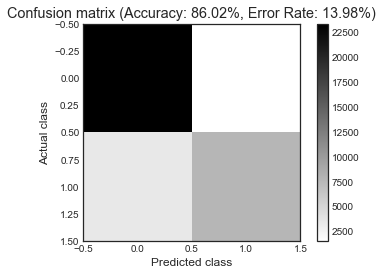

<Figure size 288x288 with 0 Axes>

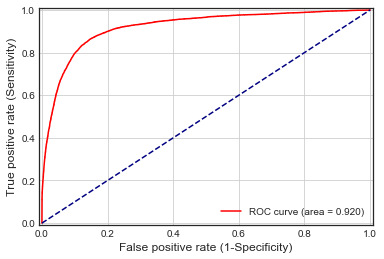

---------------------------------------------------------


K Nearest Neighbors: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     24846
         1.0       0.98      0.97      0.98     11271

    accuracy                           0.99     36117
   macro avg       0.99      0.98      0.98     36117
weighted avg       0.99      0.99      0.99     36117



<Figure size 360x360 with 0 Axes>

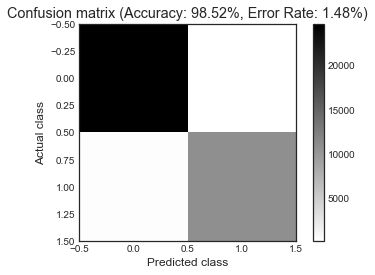

<Figure size 288x288 with 0 Axes>

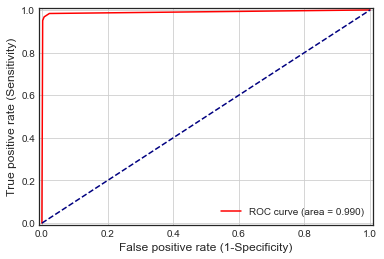

---------------------------------------------------------


Neural Networks: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     24846
         1.0       0.99      0.98      0.98     11271

    accuracy                           0.99     36117
   macro avg       0.99      0.99      0.99     36117
weighted avg       0.99      0.99      0.99     36117



<Figure size 360x360 with 0 Axes>

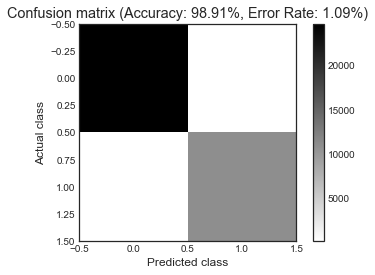

<Figure size 288x288 with 0 Axes>

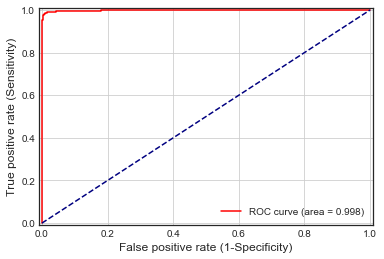

---------------------------------------------------------


Decision Tree: 
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     24846
         1.0       0.94      0.94      0.94     11271

    accuracy                           0.96     36117
   macro avg       0.96      0.96      0.96     36117
weighted avg       0.96      0.96      0.96     36117



<Figure size 360x360 with 0 Axes>

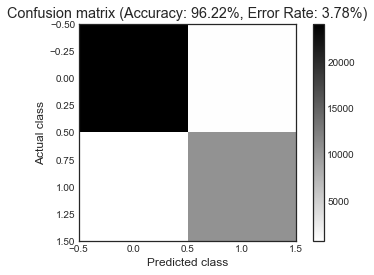

<Figure size 288x288 with 0 Axes>

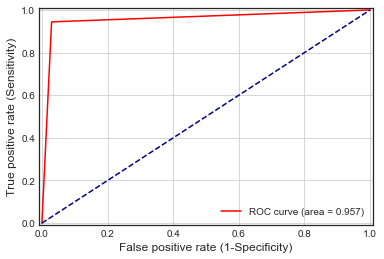

---------------------------------------------------------




In [100]:
plt.style.use('seaborn-white')
k=1
i=0
for classifier in classifiers:
    model=classifier
    model.fit(X_train, y_train)   
    
    class_rep = classification_report(y_test, model.predict(X_test))
    print(classifiers_names[i],class_rep)
   
    plt.figure(figsize=(5,5)) 
    plt.figure(k)
    plot_cm(y_test, model.predict(X_test))
    plt.show()
    
    p = model.predict_proba(X_test)[:,1]
    tpr=roc_curve(y_test,p)[0] # True Positive rate
    fpr=roc_curve(y_test,p)[1] # False Positive rate
    AUC=auc(tpr,fpr) # Area under Curve
    
    plt.figure(figsize=(4,4))
    plt.figure(k+1)
    ROC(tpr,fpr,AUC)
    plt.show()
    print("---------------------------------------------------------")
    print("\n")
    k+=2
    i+=1